In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from scipy import stats
warnings.filterwarnings("ignore")


def read_wl_csv(file_path):
    wl_df = pd.read_csv(file_path)

    ##### if the csv is from lighthouse then this drop function is always true
    ##### if the csv is not from lighthouse then you will need to modify the function

    wl_df.drop(labels=range(len(wl_df)-6,len(wl_df)), axis=0, inplace=True)

    #df_dates = 

    keys = wl_df.keys().to_list()
    
    wl_df['date'] = pd.to_datetime(wl_df[keys[0]])
    wl_df[keys[1]].replace([-999, -99, 99, 'NA', 'RM'], np.nan, inplace=True)
    wl_df[keys[2]].replace([-999, -99, 99, 'NA', 'RM'], np.nan, inplace=True)
    wl_df[keys[3]].replace([-999, -99, 99, 'NA', 'RM'], np.nan, inplace=True)
    wl_df['pwl'] = pd.to_numeric(wl_df[keys[1]],errors= 'coerce')
    wl_df['bwl'] = pd.to_numeric(wl_df[keys[2]],errors= 'coerce')
    wl_df['harmwl'] = pd.to_numeric(wl_df[keys[3]],errors= 'coerce')
    wl_df['pwl surge'] = wl_df['pwl'] - wl_df['harmwl']
    wl_df['bwl surge'] = wl_df['bwl'] - wl_df['harmwl']
    wl_df = wl_df.drop(columns=keys[0],axis=0)
    wl_df = wl_df.drop(columns=keys[1],axis=0)
    wl_df = wl_df.drop(columns=keys[2],axis=0)
    wl_df = wl_df.drop(columns=keys[3],axis=0)
    del keys
    return wl_df

def locate_gaps(WL_data):
    lengthMissVal = []
    dates = []
    count = 0
    for i in range(len(WL_data)):
        if pd.isna(WL_data['pwl surge'][i]):
            if count == 0:  # Start of a new NaN gap
                dates.append(WL_data['date'][i])  # Record the start date of the gap
            count += 1  # Increment the gap length

        else:
            if count > 0:  # End of a NaN gap
                lengthMissVal.append(count)
                count = 0  # Reset count after recording the gap length
    if count > 0:
        lengthMissVal.append(count)

    # Finalize the DataFrame
    WL_data_gaps = pd.DataFrame()
    WL_data_gaps['date'] = pd.to_datetime(dates)
    WL_data_gaps['gapLength'] = lengthMissVal
    WL_data_gaps['gapTime(min)'] = WL_data_gaps['gapLength'] * 6

    del lengthMissVal,dates,count

    return WL_data_gaps

def eligible_gap_length(WL_gaps): #Function to sort the lengh of the gaps into three categories
    WL_gaps_filter_6min = WL_gaps['gapLength'] == 1
    WL_gaps_filter = (WL_gaps['gapLength'] <= 576) & (WL_gaps['gapLength'] > 1)

    #filters the data into individual dataframes
    linear_gaps = WL_gaps[WL_gaps_filter_6min]
    gaps_less_5_days = WL_gaps[WL_gaps_filter]

    del WL_gaps_filter,WL_gaps_filter_6min

    return linear_gaps,gaps_less_5_days


def linear_fill(Wl_data,linear_gaps): #function to fill in gaps with length of 1 using linear approach

    if len(linear_gaps) > 0:

        matching_dates = Wl_data[Wl_data['date'].isin(linear_gaps['date'])]

        index_locations = matching_dates.index.tolist()

        for i in range(len(index_locations)):
            new_value = ((Wl_data.loc[(index_locations[i])-1,'pwl surge']+ Wl_data.loc[index_locations[i]+1,'pwl surge']) / 2) + Wl_data.loc[index_locations[i],'harmwl']
            Wl_data.loc[index_locations[i],'pwl'] = new_value

        del matching_dates, index_locations, new_value
        
        return Wl_data
    
    else:
        print('No single gaps to fill')

        return Wl_data


def check_bwl(Wl_data,gaps):

    if len(gaps) > 0:

        matching_dates = Wl_data[Wl_data['date'].isin(gaps['date'])]

        index_locations = matching_dates.index.tolist()

        gap_length = gaps['gapLength'].tolist()

        valid_gaps = []

        for i in range(len(index_locations)):

            is_valid = Wl_data['bwl surge'][index_locations[i]:index_locations[i]+gap_length[i]].isna().sum() == 0
            valid_gaps.append(is_valid)
        
        filtered_gaps = gaps[valid_gaps].reset_index(drop=True)

        del matching_dates, index_locations, gap_length, valid_gaps, is_valid

        return filtered_gaps
    
    else:
        print('No gaps avaliable to fill')

        return gaps


def poly_gap_fill(Wl_data, gaps):

    if len(gaps) > 0:

        poly_df_list = list()
        
        matching_dates = Wl_data[Wl_data['date'].isin(gaps['date'])]

        index_locations = matching_dates.index.tolist()

        gap_length = gaps['gapLength'].tolist()

        gap_date_list = list()

        for i in range(len(matching_dates)):

            gap_date_df = pd.DataFrame()

            gap_date_df['date'] = Wl_data['date'][index_locations[i]:index_locations[i]+gap_length[i]]

            gap_date_list.append(gap_date_df)
            


        for i in range(len(index_locations)):

            if index_locations[i]- 2161  > 0 and index_locations[i]+2161+gap_length[i] < len(Wl_data):

                pwl_30_days = Wl_data['pwl surge'][(index_locations[i]- 2160):index_locations[i]+2160+gap_length[i]].tolist()

                bwl_30_days = Wl_data['bwl surge'][(index_locations[i]- 2160):index_locations[i]+2160+gap_length[i]].tolist()

                dates = Wl_data['date'][(index_locations[i]- 2160):index_locations[i]+2160+gap_length[i]].tolist()

                linear_df = pd.DataFrame()

                linear_df['pwl 30'] = pwl_30_days
                linear_df['bwl 30'] = bwl_30_days
                linear_df['dates'] = dates

                linear_df.dropna(inplace=True)


                slope, intercept, *_ = stats.linregress(linear_df['bwl 30'],linear_df['pwl 30'])

                poly_df = pd.DataFrame({'bwl surge': bwl_30_days, 'pwl surge': pwl_30_days,'date' : pd.to_datetime(dates)})

                poly_df['mwl surge linear'] = intercept + slope*poly_df['bwl surge']



                outliers = poly_df[abs(poly_df['mwl surge linear'] - poly_df['pwl surge']) > 0.1]

                print(f"Number of outliers detected: {len(outliers)}")

                mask = abs(poly_df['mwl surge linear'] - poly_df['pwl surge']) > 0.1
                
                poly_df.loc[mask, 'pwl surge'] = np.nan
                poly_df.loc[mask, 'mwl surge linear'] = np.nan
                poly_df.loc[mask, 'bwl surge'] = np.nan
                
                '''plt.scatter(poly_df['pwl surge'], poly_df['bwl surge'])

                plt.scatter(poly_df['mwl surge linear'],poly_df['bwl surge'] , color = 'red', linestyle = 'dashed', label = 'linear model')

                plt.title('pwl surge vs bwl surge')

                plt.show()

                plt.clf()'''
                
            

                
                if poly_df['bwl surge'].isna().sum() + poly_df['pwl surge'].isna().sum() < len(Wl_data)*0.1:

                    poly_df_copy = poly_df.copy()

                    poly_df_copy.dropna(inplace=True)

                    poly =np.polynomial.polynomial.Polynomial.fit(poly_df_copy['pwl surge'],poly_df_copy['bwl surge'],4)

                    coeffs = np.polyfit(poly_df_copy['bwl surge'],poly_df_copy['pwl surge'],4)

                    poly1 = np.poly1d(coeffs)

                    pred_values = poly1(poly_df['bwl surge'])

                    poly_df['mwl surge'] = pred_values

                    '''plt.scatter([poly_df['pwl surge']], poly_df['bwl surge'])

                    plt.scatter(poly_df['mwl surge'],poly_df['bwl surge'], color = 'black', linestyle = 'dashed')

                    plt.title('pwl surge vs bwl surge (poly)')

                    plt.show()

                    plt.clf()'''

                    poly_df_list.append(poly_df)

                    del poly_df_copy, poly, pred_values


                else:
                   print('Can not fill gap not enough points')


            else:
                print('Can not fill gap out of bounds')
        

        return poly_df_list, index_locations, gap_length, gap_date_list


    else:
        print('No gaps to Fill')
        index_locations  = []
        gap_length = []
        gap_date_list=[]

        poly_df_list = []

        return poly_df_list, index_locations, gap_length, gap_date_list

def fill_gaps(poly_list, gap_dates_list, wl_df):
    matched_dates1 = []
    matched_dates2 = []

    # Process each gap and its corresponding poly_df
    for gap_df, poly_df in zip(gap_dates_list, poly_list):
        # Ensure dates are in datetime format
        gap_df['date'] = pd.to_datetime(gap_df['date'])
        poly_df['date'] = pd.to_datetime(poly_df['date'])

        # Find common dates between gap_df and poly_df
        common_dates = gap_df['date'][gap_df['date'].isin(poly_df['date'])]

        # Filter both DataFrames for the common dates
        filtered_gap_df = gap_df[gap_df['date'].isin(common_dates)]
        filtered_poly_df = poly_df[poly_df['date'].isin(common_dates)]

        # Append the filtered DataFrames
        matched_dates1.append(filtered_gap_df)
        matched_dates2.append(filtered_poly_df)

    # Combine all matched DataFrames
    match_df_1 = pd.concat(matched_dates1, ignore_index=True)
    match_df_2 = pd.concat(matched_dates2, ignore_index=True)

    # Merge the poly_df data with the original wl_df
    Wl_data_total = match_df_2.merge(wl_df, on='date', how='outer')

    # Clean up columns
    Wl_data_total = Wl_data_total.drop(columns=['bwl surge_x', 'pwl surge_x', '#date+time'], errors='ignore')
    Wl_data_total['pwl surge'] = Wl_data_total.get('pwl surge_y', None)
    Wl_data_total['bwl surge'] = Wl_data_total.get('bwl surge_y', None)
    Wl_data_total = Wl_data_total.drop(columns=['pwl surge_y', 'bwl surge_y'], errors='ignore')

    # Clean up memory by deleting unnecessary variables
    del poly_list, gap_dates_list, matched_dates1, matched_dates2, match_df_1, match_df_2

    return Wl_data_total  

def adjustment(filled_df,index_locations,gap_length):

    adj_list = []

    for i in range(len(index_locations)):

        average_before_gap = np.mean(filled_df['pwl surge'][(index_locations[i]-6):index_locations[i]].tolist())
        average_after_gap = np.mean(filled_df['pwl surge'][(index_locations[i]+1+gap_length[i]):index_locations[i]+6+gap_length[i]].tolist())

        n_length = gap_length[i]

        

        for k in range(n_length):

            adjustment = (average_after_gap+(k/n_length)) * (average_before_gap - average_after_gap)

            adj_list.append(adjustment)

    filled_df['mwl surge adjusted'] = filled_df['mwl surge']
        
    non_nan_mask = ~filled_df['mwl surge adjusted'].isna()

    non_nan_indices = filled_df[non_nan_mask].index

    for idx, val in zip(non_nan_indices[:len(adj_list)], adj_list):
        filled_df.at[idx, 'mwl surge adjusted'] += val




    return filled_df

def create_gaps(dataset):

    import random

    wl_data =  dataset.copy() #pd.DataFrame(dataset)

    random_index = [random.randint(0,len(wl_data))for _ in range(1000)]

    max_gap_size = 100
    random_index = random.sample(range(len(wl_data) - max_gap_size), 1000)

    #print(len(random_index))

    #create one six min gap

    wl_data.loc[random_index[0], 'pwl surge'] = np.nan
    random_index = random_index[1:]


    # create 5 30 min gaps

    for i in range(5):

        wl_data.loc[random_index[i]:random_index[i] + 4, 'pwl surge'] = np.nan
    
    random_index = random_index[5:]

    #create 10 1hr gaps

    for i in range(10):

        wl_data.loc[random_index[i]:random_index[i] + 9, 'pwl surge'] = np.nan
    
    random_index = random_index[10:]

    #creates 50 5 hr gaps

    for i in range(50):

        wl_data.loc[random_index[i]:random_index[i] + 49, 'pwl surge'] = np.nan
    
    random_index = random_index[50:]

    #creates 100 10hr gaps

    for i in range(100):

        wl_data.loc[random_index[i]:random_index[i] + 99, 'pwl surge'] = np.nan
    
    random_index = random_index[100:]


    #print((wl_data.isna().sum()))

    return wl_data




    

In [2]:
def cbi_gapfill(filepath):

    print('Reading dataset')
    wl_dataset = read_wl_csv(filepath)

    #wl_dataset_gaps = create_gaps(wl_dataset)

    #print('Gaps Created')

    Wl_gaps = locate_gaps(wl_dataset)

    print('Total number of gaps: ', len(Wl_gaps))

    linear_gaps,multi_gaps = eligible_gap_length(Wl_gaps)

    print('Number of Linear Gaps filled:', len(linear_gaps))

    dataset_LF = linear_fill(wl_dataset,linear_gaps)

    print('Single gaps filled')

    valid_multi_gaps = check_bwl(dataset_LF,multi_gaps)

    #print(valid_multi_gaps)

    print('Number of gaps with backup water level:', len(valid_multi_gaps))

    poly_wl_list, index_location, gap_length, gap_list = poly_gap_fill(dataset_LF,valid_multi_gaps)

    if len(poly_wl_list) > 0 :

        filled_df = fill_gaps(poly_wl_list,gap_list,dataset_LF)

        adjusted_gaps = adjustment(filled_df,index_location,gap_length)

        print('Gaps filled', + len(poly_wl_list))

        return filled_df, wl_dataset, Wl_gaps, dataset_LF, poly_wl_list, gap_list, adjusted_gaps
    
    else:
        adjusted_gaps = []

        return dataset_LF, wl_dataset, Wl_gaps, dataset_LF, poly_wl_list, gap_list, adjusted_gaps

    #complete_dataset = adjustment(filled_wl_dataset,index_location,gap_length)

    

filled_df, wl_dataset, all_gaps, dataset_LF, poly_wl, filled_gap_list, adjusted_gaps = cbi_gapfill(r'/Users/rprocious/Waterlevels_CBI/CBI-2/Gap_Filling/P21_2016_gaps.csv')



Reading dataset


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rprocious/Waterlevels_CBI/CBI-2/Gap_Filling/P21_2016_gaps.csv'

In [ ]:
filled_df

,date,mwl surge linear,mwl surge,pwl,bwl,harmwl,pwl surge,bwl surge,mwl surge adjusted
0,2016-01-01 00:00:00,NaN,NaN,1.805,2.619,1.436,0.369,1.183,NaN
1,2016-01-01 00:06:00,NaN,NaN,1.808,2.622,1.441,0.367,1.181,NaN
2,2016-01-01 00:12:00,NaN,NaN,1.826,2.634,1.446,0.380,1.188,NaN
3,2016-01-01 00:18:00,NaN,NaN,1.843,2.647,1.451,0.392,1.196,NaN
4,2016-01-01 00:24:00,NaN,NaN,1.850,2.650,1.456,0.394,1.194,NaN
...,...,...,...,...,...,...,...,...,...
87829,2016-12-31 22:54:00,NaN,NaN,2.009,2.756,1.499,0.510,1.257,NaN
87830,2016-12-31 23:00:00,NaN,NaN,2.028,2.767,1.506,0.522,1.261,NaN
87831,2016-12-31 23:06:00,NaN,NaN,2.016,2.760,1.512,0.504,1.248,NaN
87832,2016-12-31 23:12:00,NaN,NaN,2.036,2.774,1.519,0.517,1.255,NaN


(16965.229166666668, 16965.979166666668)

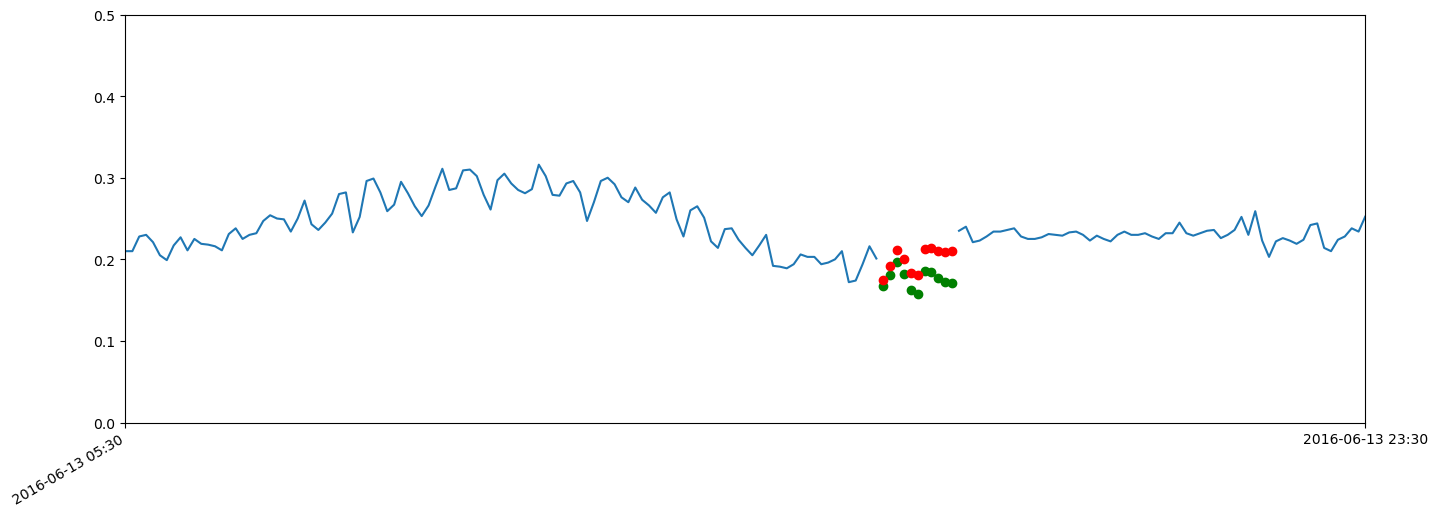

In [ ]:
plt.figure(figsize=(16,6))

plt.scatter(filled_df['date'], filled_df['mwl surge adjusted'], color = 'green')

plt.plot(wl_dataset['date'],wl_dataset['pwl surge'])

plt.scatter(filled_df['date'], filled_df['mwl surge'], color = 'red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=400))

plt.gcf().autofmt_xdate()

plt.ylim(0,0.5)

start_date = pd.to_datetime('2016-06-13 05:30:00')

end_date = pd.to_datetime('2016-06-13 23:30:00')

plt.xlim(start_date, end_date)

In [ ]:
filled_df['pwl surge actual'] = wl_dataset['pwl surge']

filled_df['pwl new'] = filled_df['mwl surge'] + filled_df['harmwl']

filled_df['error'] = (abs(filled_df['pwl surge actual'] - filled_df['mwl surge'])) / filled_df['pwl surge actual'] * 100
filled_df['error'].replace([np.inf, -np.inf], np.nan, inplace=True)

filled_df.describe()

,date,mwl surge linear,mwl surge,pwl,bwl,harmwl,pwl surge,bwl surge,mwl surge adjusted,pwl surge actual,pwl new,error
count,87834,123.000000,123.000000,86134.000000,86269.000000,87834.000000,86126.000000,86269.000000,123.000000,86126.000000,123.000000,0.0
mean,2016-07-01 23:39:00,0.196792,0.197065,1.818893,2.617884,1.555960,0.263647,1.062525,0.223466,0.263647,1.887829,NaN
min,2016-01-01 00:00:00,0.109501,0.098004,0.585000,0.000000,1.035000,-0.617000,-1.609000,0.147212,-0.617000,1.848001,NaN
25%,2016-04-01 11:49:30,0.137997,0.135264,1.692000,2.526000,1.458000,0.187000,0.994000,0.177776,0.187000,1.862319,NaN
50%,2016-07-01 23:39:00,0.187865,0.192153,1.835000,2.628000,1.573000,0.262000,1.056000,0.205546,0.262000,1.881116,NaN
75%,2016-10-01 11:28:30,0.220941,0.225439,1.966000,2.722000,1.675000,0.342000,1.128000,0.240799,0.342000,1.899835,NaN
max,2016-12-31 23:18:00,0.367917,0.366793,2.507000,3.124000,1.917000,0.894000,1.593000,0.379508,0.894000,1.987908,NaN
std,NaN,0.067643,0.069534,0.220356,0.158956,0.158708,0.147157,0.115142,0.062486,0.147157,0.032960,NaN
